# 8.5. Bridge design problem

```{note}
Press the rocket symbol on the top right of the page to make the page interactive and play with the code! 
```

## Problem statement 

Consider a bridge design where we limit the design problem to the determination of
the optimal span and the clearance height of the bridge. Assume that there are two
decision makers (stakeholders) that have conflicting interests: 
1) the municipality interested in the costs of the bridge, and 
2) the waterway users interested in the
waiting time when the bridge is closed for waterway users. 


- **Step 1: Specify the design variables**

For this problem we have two controllable design variables:
1) the bridge span $x_1$ and 
2) the clearance height of the bridge $x_2$. 

- **Step 2: Retrieve decision maker's objectives**

The municipality wants the cost to be minimised which becomes the first objective function $O_1$, whereas the waterway users want the waiting time to be minimised which becomes the second objective function $O_2$.

- **Step 3: Determine the preference functions for each objective**

The costs are a function of the material use which in turn is a function of both the span and clearance height. We assume a linear relationship between costs $O_1$ and material use $F_1$ defined by coefficient $c_1 = 3$.

$$O_1 = c_1 F_1$$

We also assume a linear relationship between material use and both span and clearance height defined by coefficients $c_2 = 4$ and $c_3 = 7$ respectively.

$$F_1 = c_2 x_1 + c_3 x_2$$

The first objective to be minimised then becomes:

$$O_1 = c_1 F_1 = c_1 c_2 x_1 + c_1 c_3 x_2$$

The waiting time is a function of the traffic flow which in turn is a function of both the span and clearance height. We again assume a linear relationship between waiting time $O_2$ and traffic flow $F_2$, and reads as:

$$O_2 = −c_4 F_2 + w_0; F_2 = c_5 x_1 + c_6 x_2$$

where $w_0 > 0$. 

We also assume: 
(a) the coefficient $c_4 = 1.2$;
(b) a maximal waiting time of $w_0 = 100$ (for a traffic flow that is ’nearly’ zero); 
(c) a linear relationship between traffic flow and both span and clearance height defined by coefficients $c_5 = 1.7$ and $c_6 = 1.9$ respectively. 

The second objective to be minimised then becomes:

$$O_2 = −c_4 F_2 + w_0 = −c_4 c_5 x_1 − c_4 c_6 x_2 + w_0$$

- **Step 4: To each objective assign decision maker's weights**

For this problem the weights are assumed to be equal, i.e. $w_1 = w_2 = 0.5$.


- **Step 5: Determine the design constraints**

The constraints relate to the minimum and maximum span and the minimum and
and maximum clearance height:

$$1 ≤ x_1 ≤ 5; 3 ≤ x_2 ≤ 8$$


- **Step 6: Find the optimal design having the highest preference score**

The graphical representation of this problem and both optimal solutions are shown in the figure below. The design points are $(x1, x2) = (1, 3)$ and $(5, 8)$ for costs and waiting time respectively. 

<div style="text-align: center;">
  <img src="./images/bridge_results.png" alt="Chapter 11" width="70%">
  <p>Graphical representation of the bridge design problem.</p>
</div>

## Python code for bridge design problem

Type of algorithm used for single objective optimisation: Scipy minimize and MILP \
Type of algorithm used for multi objective optimisation: Genetic Algorithm (tetra) \
Number of design variables: 2 \
Number of objective functions: 2 \
Bounds: yes \
Constraints: no \
Type of problem: linear 

In [46]:
import micropip
await micropip.install("urllib3 ")
await micropip.install("requests")

import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint, milp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from genetic_algorithm_pfm.a_fine_aggregator_main import a_fine_aggregator

%matplotlib inline
plt.rcParams['figure.dpi'] = 400
plt.rcParams.update({'font.size': 14})

### MILP and Minimise

Scipy has two algorithms that can easily be used for optimisation: MILP and Minimize. The former is especially useful for mixed-integer problems: problems where one or more of the variables is an integer variable. The latter is, however, more straightforward in its use.

To show their applicability, the same problem is worked out with both methods in this notebook.

In [47]:
# define constants
c1 = 3   # costs per material
c2 = 4   # material used per metre bridge span
c3 = 7   # material used per metre air draft
c4 = 1.2   # relation between waiting time and traffic flow
c5 = 1.7   # traffic flow per metre bridge span
c6 = 1.9   # traffic flow per metre air draft

WT0 = 100   # minimal waiting time

#### MILP

In [48]:
# first, define the objective function. Since it is linear, we can just provide the coefficients with which x1 and x2
# are multiplied. Note the -1: we need to maximize, however, milp is a minimization algorithm!
c_costs = 1 * np.array([c1 * c2, c1 * c3])
c_wait_time = -1 * np.array([c4 * c5, c4 * c6])

# next, define the constraints. For this we first provide a matrix A with all the coefficients x1 and x2 are multiplied.
A = np.array([[1, 0], [0, 1]])

# next we determine the upper bounds as vectors
b_u = np.array([5, 8])

# finally, we need to define the lower bound. In our case, these are taken as 0
b_l = np.array([1, 3])

# we can now define the LinearConstraint
constraints = LinearConstraint(A, b_l, b_u)

# the integrality array will tell the algorithm what type of variables (0 = continuous; 1 = integer) there are
integrality = np.zeros_like(c_costs)

# Run the optimization
result1 = milp(c=c_costs, constraints=constraints, integrality=integrality)
result2 = milp(c=c_wait_time, constraints=constraints, integrality=integrality)

print('Results MILP')
print(f'Objective 1 is minimal for x1 = {result1.x[0]} and x2 = {result1.x[1]}. The costs are then {result1.fun}.')
print(f'Objective 2 is minimal for x1 = {result2.x[0]} and x2 = {result2.x[1]}. '
      f'The wait time is then {result2.fun + WT0}.')

Results MILP
Objective 1 is minimal for x1 = 1.0 and x2 = 3.0. The costs are then 75.0.
Objective 2 is minimal for x1 = 5.0 and x2 = 8.0. The wait time is then 71.56.


#### Minimize

In [49]:
# define objectives
def objective_costs(x):
    x1, x2 = x

    F1 = c2 * x1 + c3 * x2

    return c1 * F1


def objective_wait_time(x):
    x1, x2 = x

    F2 = c5 * x1 + c6 * x2

    return -1 * c4 * F2 + WT0


# define bounds for two variables
bounds = ((1, 5), (3, 8))

# initiate optimization
result1 = minimize(objective_costs, x0=np.array([1, 1]), bounds=bounds)
result2 = minimize(objective_wait_time, x0=np.array([1, 1]), bounds=bounds)

optimal_result_O1 = result1.fun
optimal_result_O2 = result2.fun

# print results
print('Results Minimize')
print(f'Objective 1 is minimal for x1 = {result1.x[0]} and x2 = {result1.x[1]}. The costs are then {result1.fun}.')
print(f'Objective 2 is minimal for x1 = {result2.x[0]} and x2 = {result2.x[1]}. The wait time is then {result2.fun}.')
print()

Results Minimize
Objective 1 is minimal for x1 = 1.0 and x2 = 3.0. The costs are then 75.0.
Objective 2 is minimal for x1 = 5.0 and x2 = 8.0. The wait time is then 71.56.



#### Plot the results

After optimising using the minimise algorithm the solution space and the objective function are plotted.

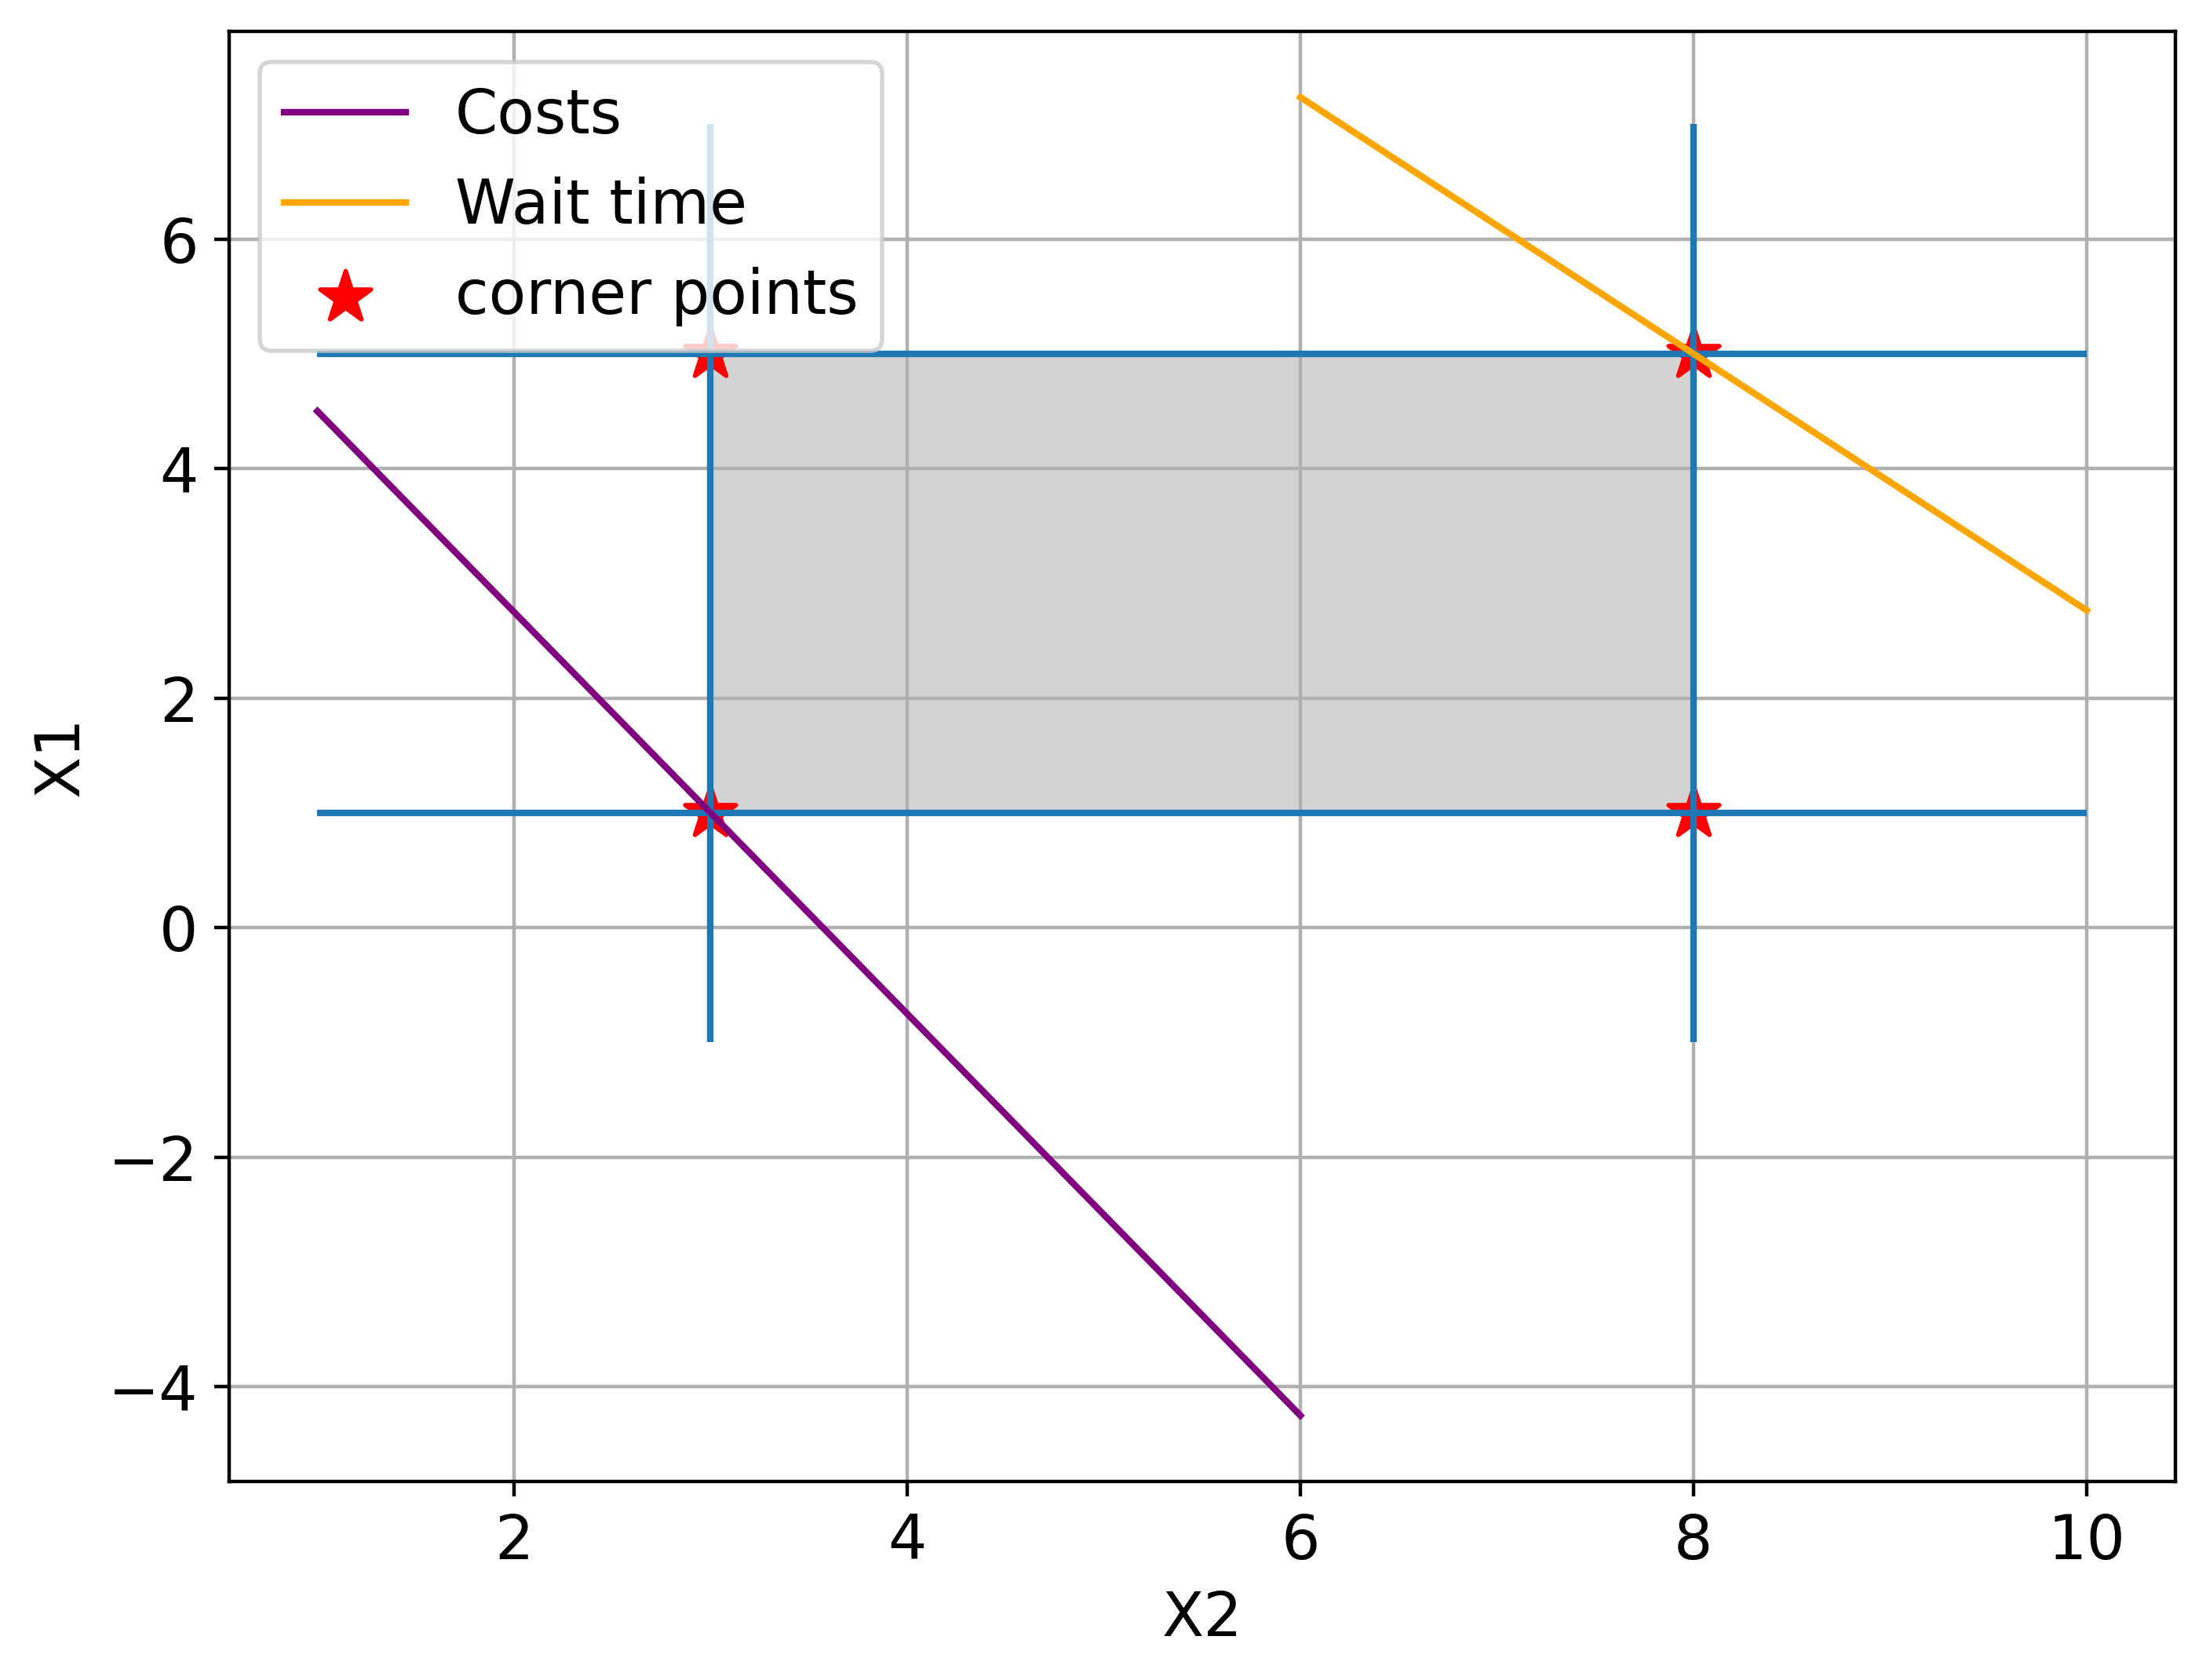

In [50]:
# plot graphical solution
fig, ax = plt.subplots(figsize=(8, 6))

# Draw constraint lines
ax.vlines(3, -1, 7)
ax.vlines(8, -1, 7)
ax.hlines(1, 1, 10)
ax.hlines(5, 1, 10)

# Draw the feasible region
feasible_set = Polygon(np.array([[3, 1],
                                 [8, 1],
                                 [8, 5],
                                 [3, 5]]),
                       color="lightgrey")
ax.add_patch(feasible_set)

ax.set_xlabel('X2')
ax.set_ylabel('X1')

# Draw the objective function
x2 = np.linspace(1, 6)
ax.plot(x2, (optimal_result_O1 - c1 * c3 * x2) / (c1 * c2), color="purple", label='Costs')
x2 = np.linspace(6, 10)
ax.plot(x2, (WT0 - c4 * c6 * x2 - optimal_result_O2) / (c4 * c5), color="orange", label='Wait time')

ax.scatter([3,3,8,8], [1,5,1,5], marker='*', color='red', label='corner points', s=150)

ax.legend()
ax.grid();


### Corner point evaluation

Now the corner points of the solution space can be evaluated using the Tetra solver. 

In [51]:
# corner point evaluation with Tetra
def preference_P1(variables):
    x1 = variables[:, 0]
    x2 = variables[:, 1]

    costs = objective_costs([x1, x2])
    return 7600 / 51 - 100 * costs / 153

def preference_P2(variables):
    x1 = variables[:, 0]
    x2 = variables[:, 1]

    wait_time = objective_wait_time([x1, x2])
    return 291.747 - 2.67953 * wait_time


alternatives = np.array([
    [1, 3],
    [1, 8],
    [5, 3],
    [5, 8]
])

P1 = preference_P1(alternatives)
P2 = preference_P2(alternatives)

w = [0.5, 0.5] # weights are equal here
p = [P1, P2]

ret = a_fine_aggregator(w, p)

# add results to DataFrame and print it
results = np.zeros((4, 3))
results[:, 0] = alternatives[:, 0]
results[:, 1] = alternatives[:, 1]
results[:, 2] = np.multiply(-1, ret)

df = pd.DataFrame(np.round_(results, 2), columns=['x1', 'x2', 'Aggregated preference'])
print(df)

    x1   x2  Aggregated preference
0  1.0  3.0                  36.68
1  1.0  8.0                   0.00
2  5.0  3.0                 100.00
3  5.0  8.0                  63.32


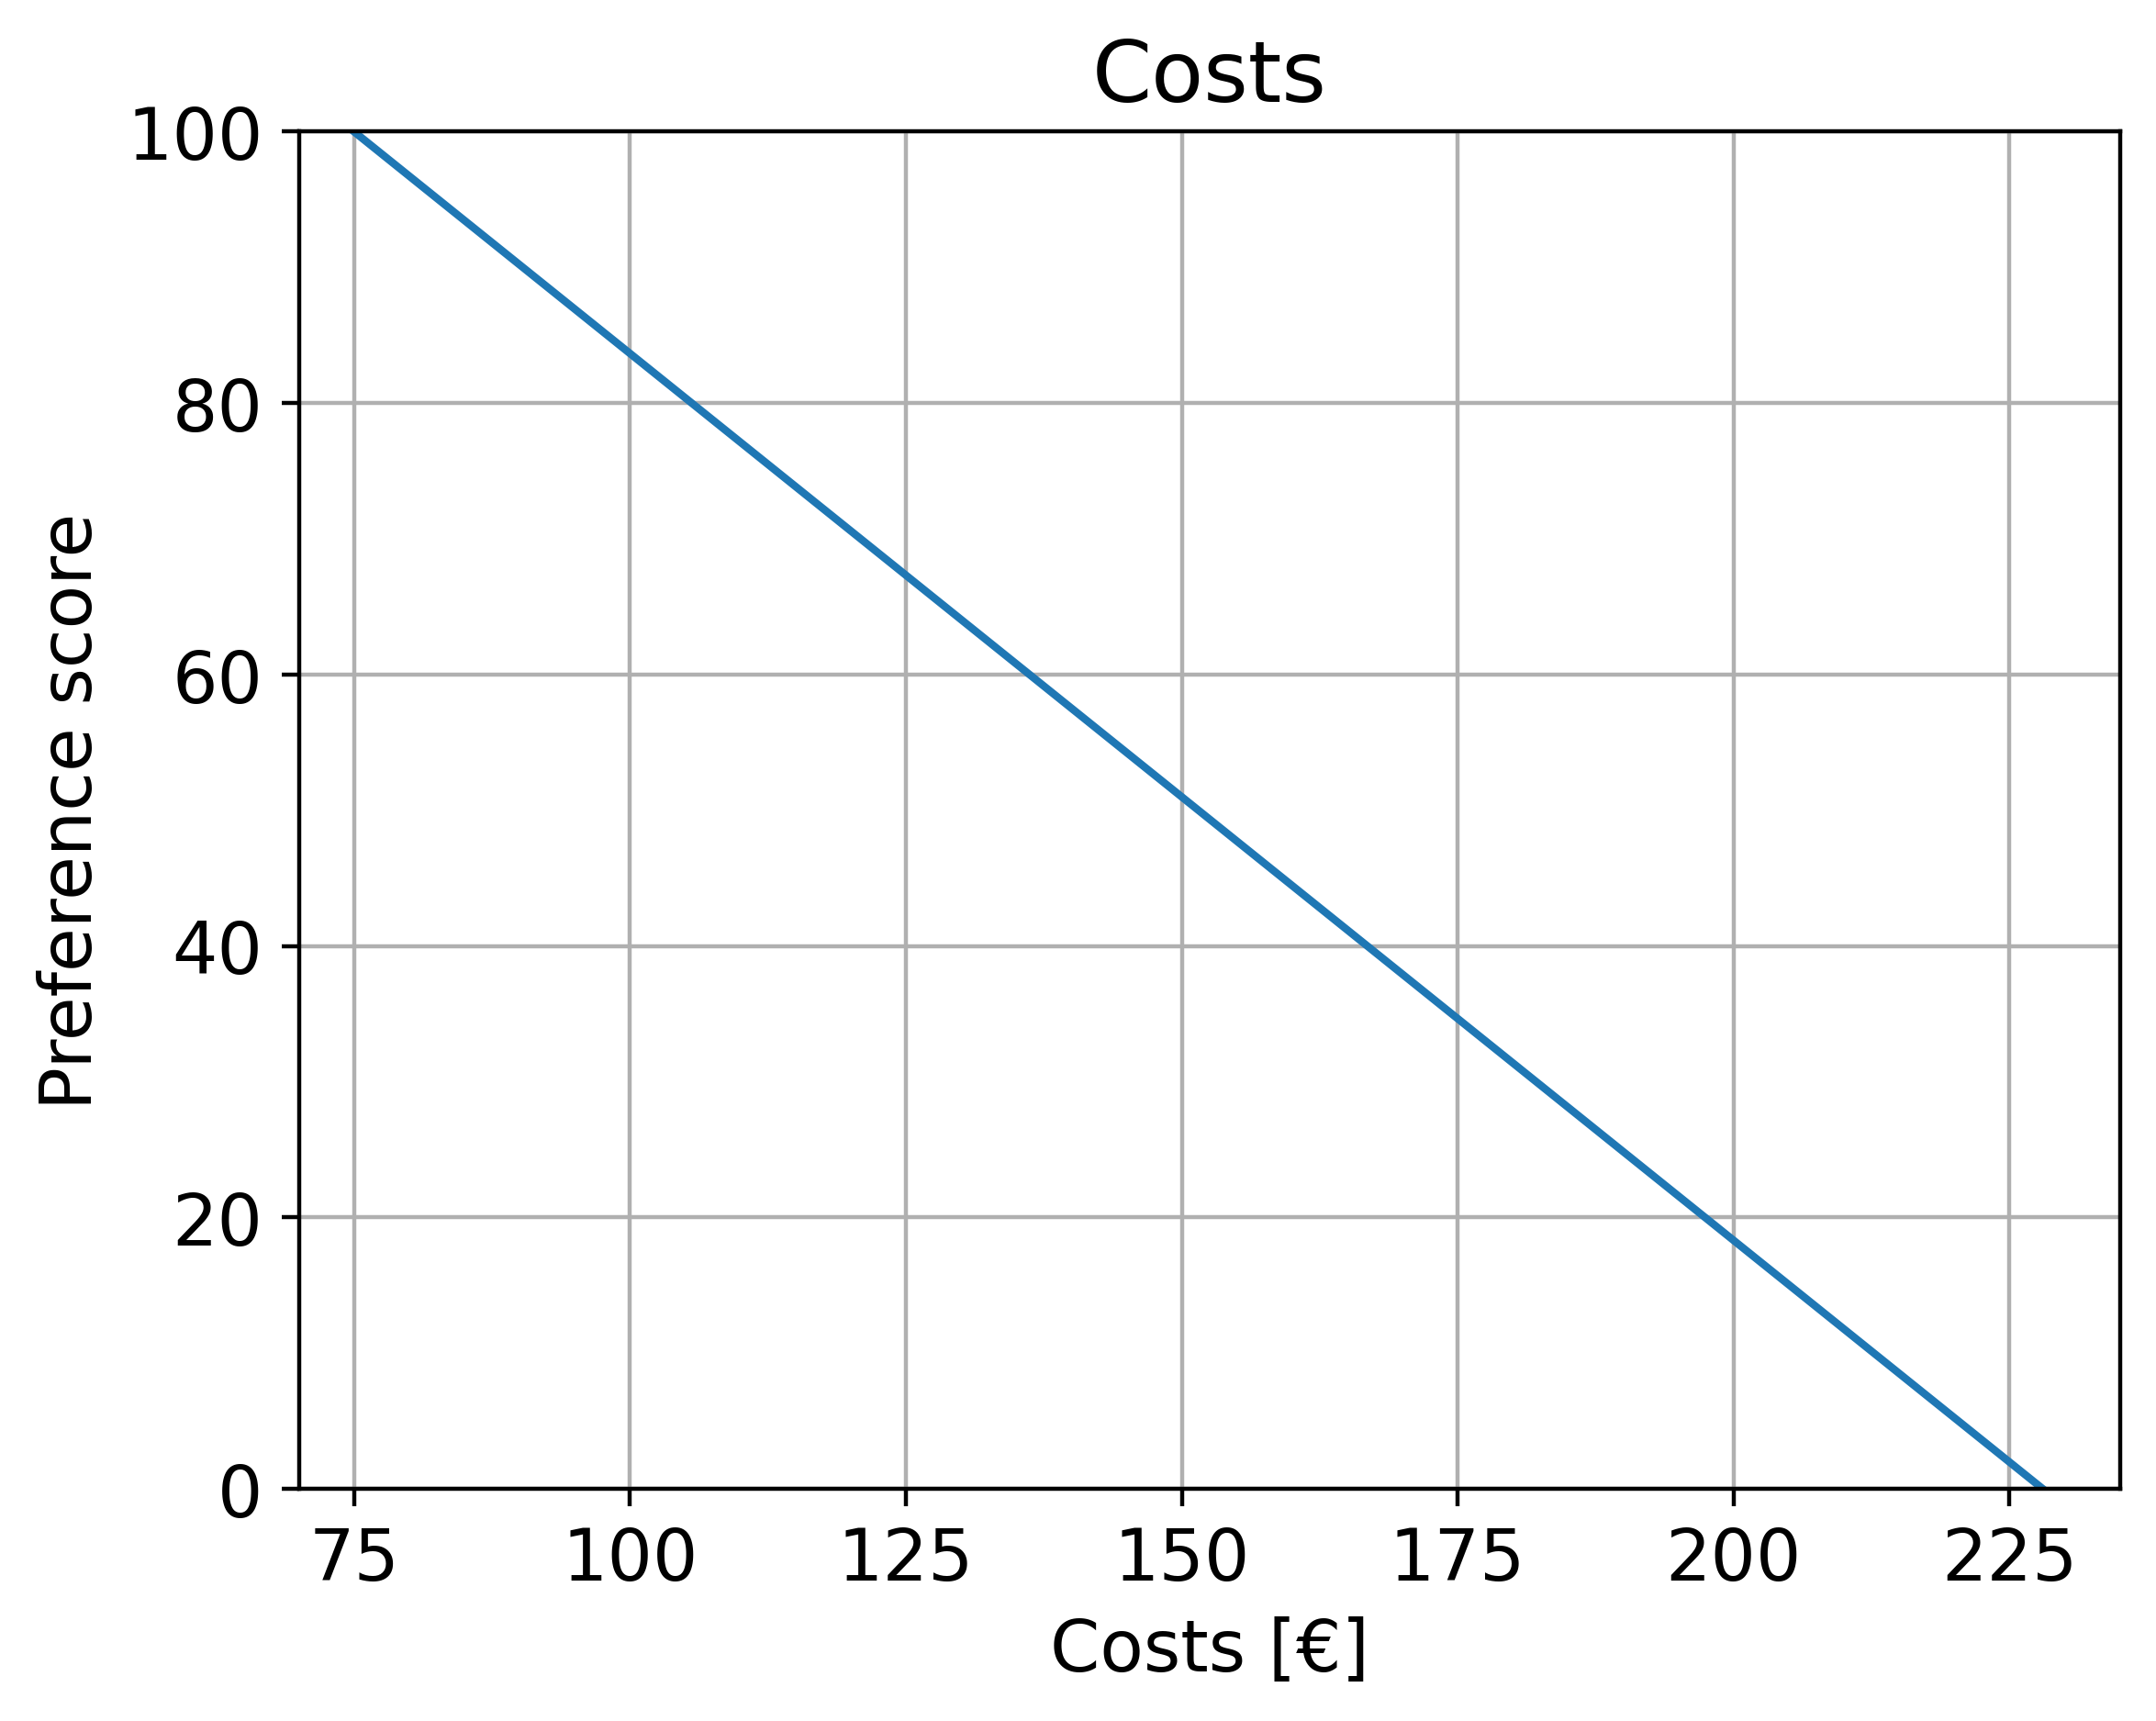

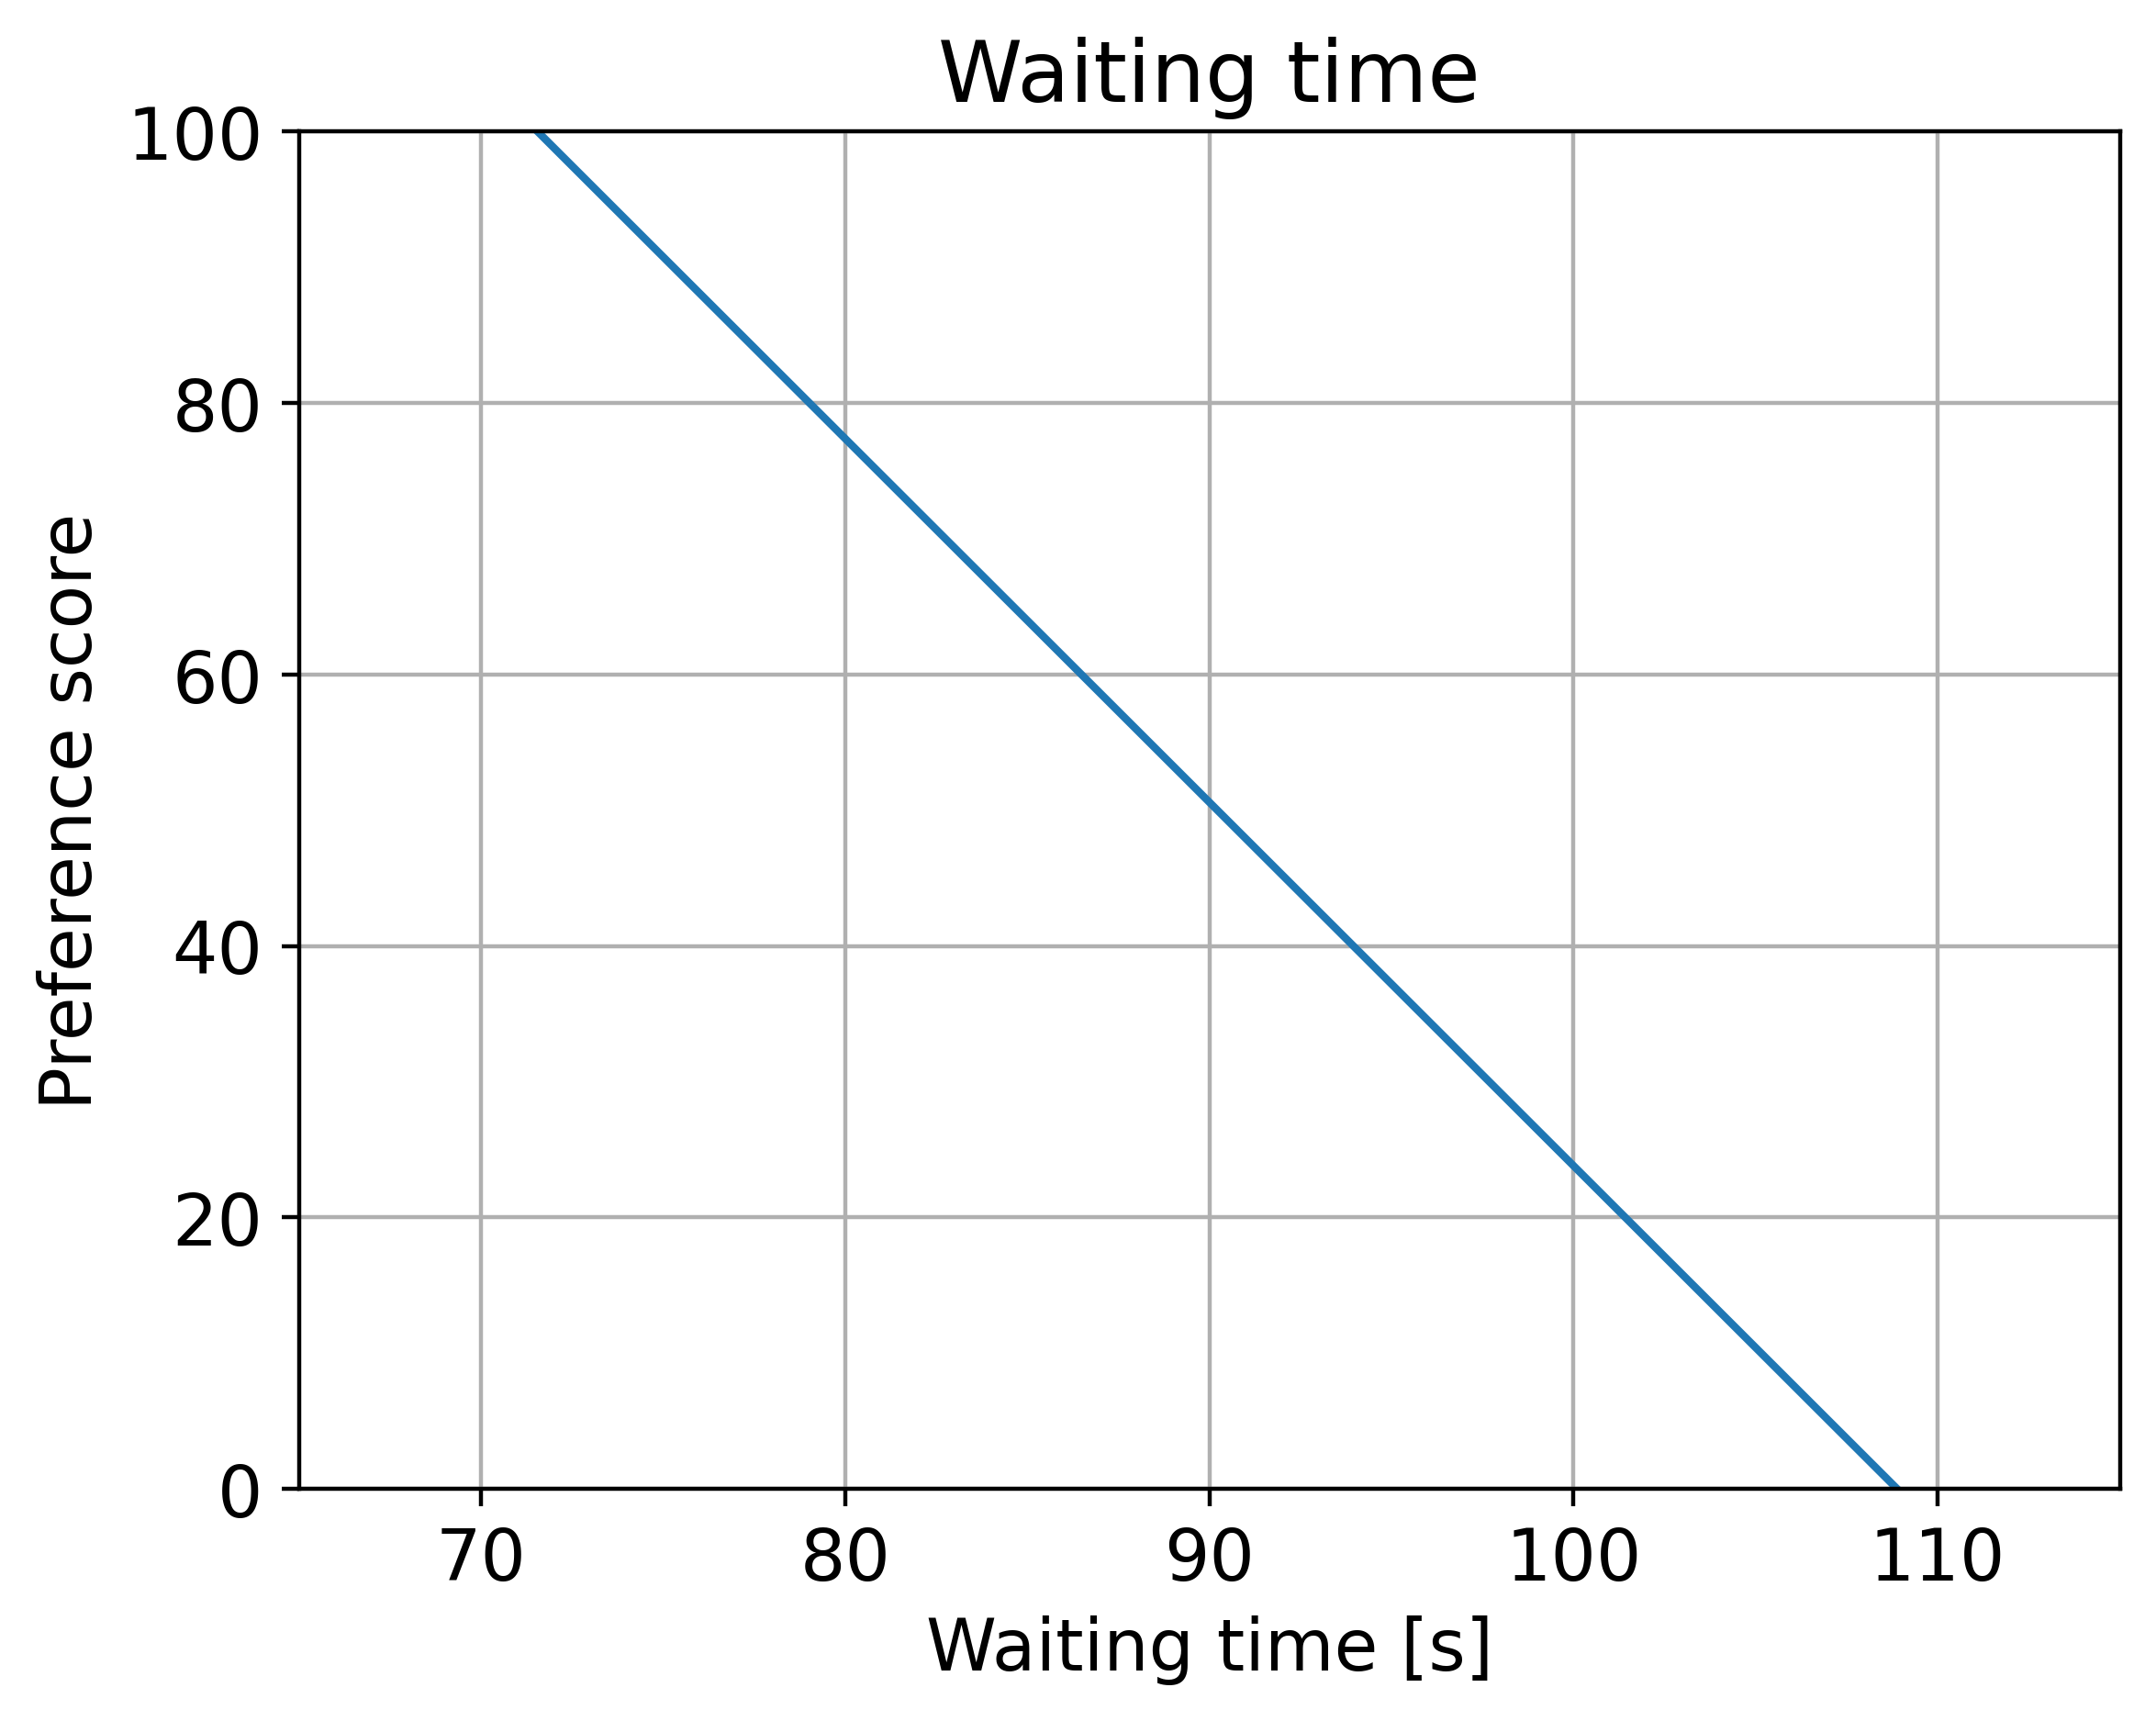

In [52]:
constants_1 = np.linspace(75, 228)
constants_2 = np.linspace(71.56, 108.88)

pref_1 = 7600 / 51 - 100 * constants_1 / 153
pref_2 = 291.747 - 2.67953 * constants_2

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(constants_1, pref_1)
ax1.set_xlim((70, 235))
ax1.set_ylim((0, 100))
ax1.set_title('Costs')
ax1.set_xlabel('Costs [€]')
ax1.set_ylabel('Preference score')
ax1.grid()

fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(constants_2, pref_2)
ax2.set_xlim((65, 115))
ax2.set_ylim((0, 100))
ax2.set_title('Waiting time')
ax2.set_xlabel('Waiting time [s]')
ax2.set_ylabel('Preference score')
ax2.grid()

### A priori optimisation

The optimisation above initially considers only the single stakeholders and evaluates only the corner points. However, as you will in other examples, this is no guarantee that the optimal solution is found. Here, the optimal point is not on any of the corners. To find the optimal solutions in these cases, a multi-objective optimisation is performed. 

The same is showed below for the bridge problem, so you can see how the single-objective optimisations, the multi-objective evaluation, and the multi-objective optimisation relate to each other.

In [53]:
from genetic_algorithm_pfm import GeneticAlgorithm

weights = [0.5, 0.5]

def objective(variables):
    p1 = preference_P1(variables)
    p2 = preference_P2(variables)

    return weights, [p1, p2]

bounds = [[1, 5], [3, 8]]
options = {
    'aggregation': 'a_fine',
    "n_pop": 120,
    "max_stall": 60,
    "n_iter": 1000,
    "n_bits": 8,
    "r_cross": 0.9
}

# run the GA and print its result
ga = GeneticAlgorithm(objective=objective, constraints=[], bounds=bounds, options=options)
score, design_variables, _ = ga.run()

print()
print('Results multi-objective optimisation')
print(f'x1 = {design_variables[0]} and x2 = {design_variables[1]}.')

The type of aggregation is set to a_fine
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
No initial starting point for the optimization with the a-fine-aggregator is given. A random population is generated.
0            -100.0       -34.3212         1            0.017        0           
1            -100.0       -79.5951         2            0.188        0           
2            -100.0       -79.7827         1            0.342        0           
3            -100.0       -91.3552         2            0.221        0           
4            -100.0       -91.6844         1            0.429        0           
5            -100.0       -92.7016         2            0.412        0           
6            -100.0       -89.0771         3            0.392        0           
7            -100.0       -91.1093         4            0.421        0           
8            -100.0       -95.6549         5            0.446        0           
9  

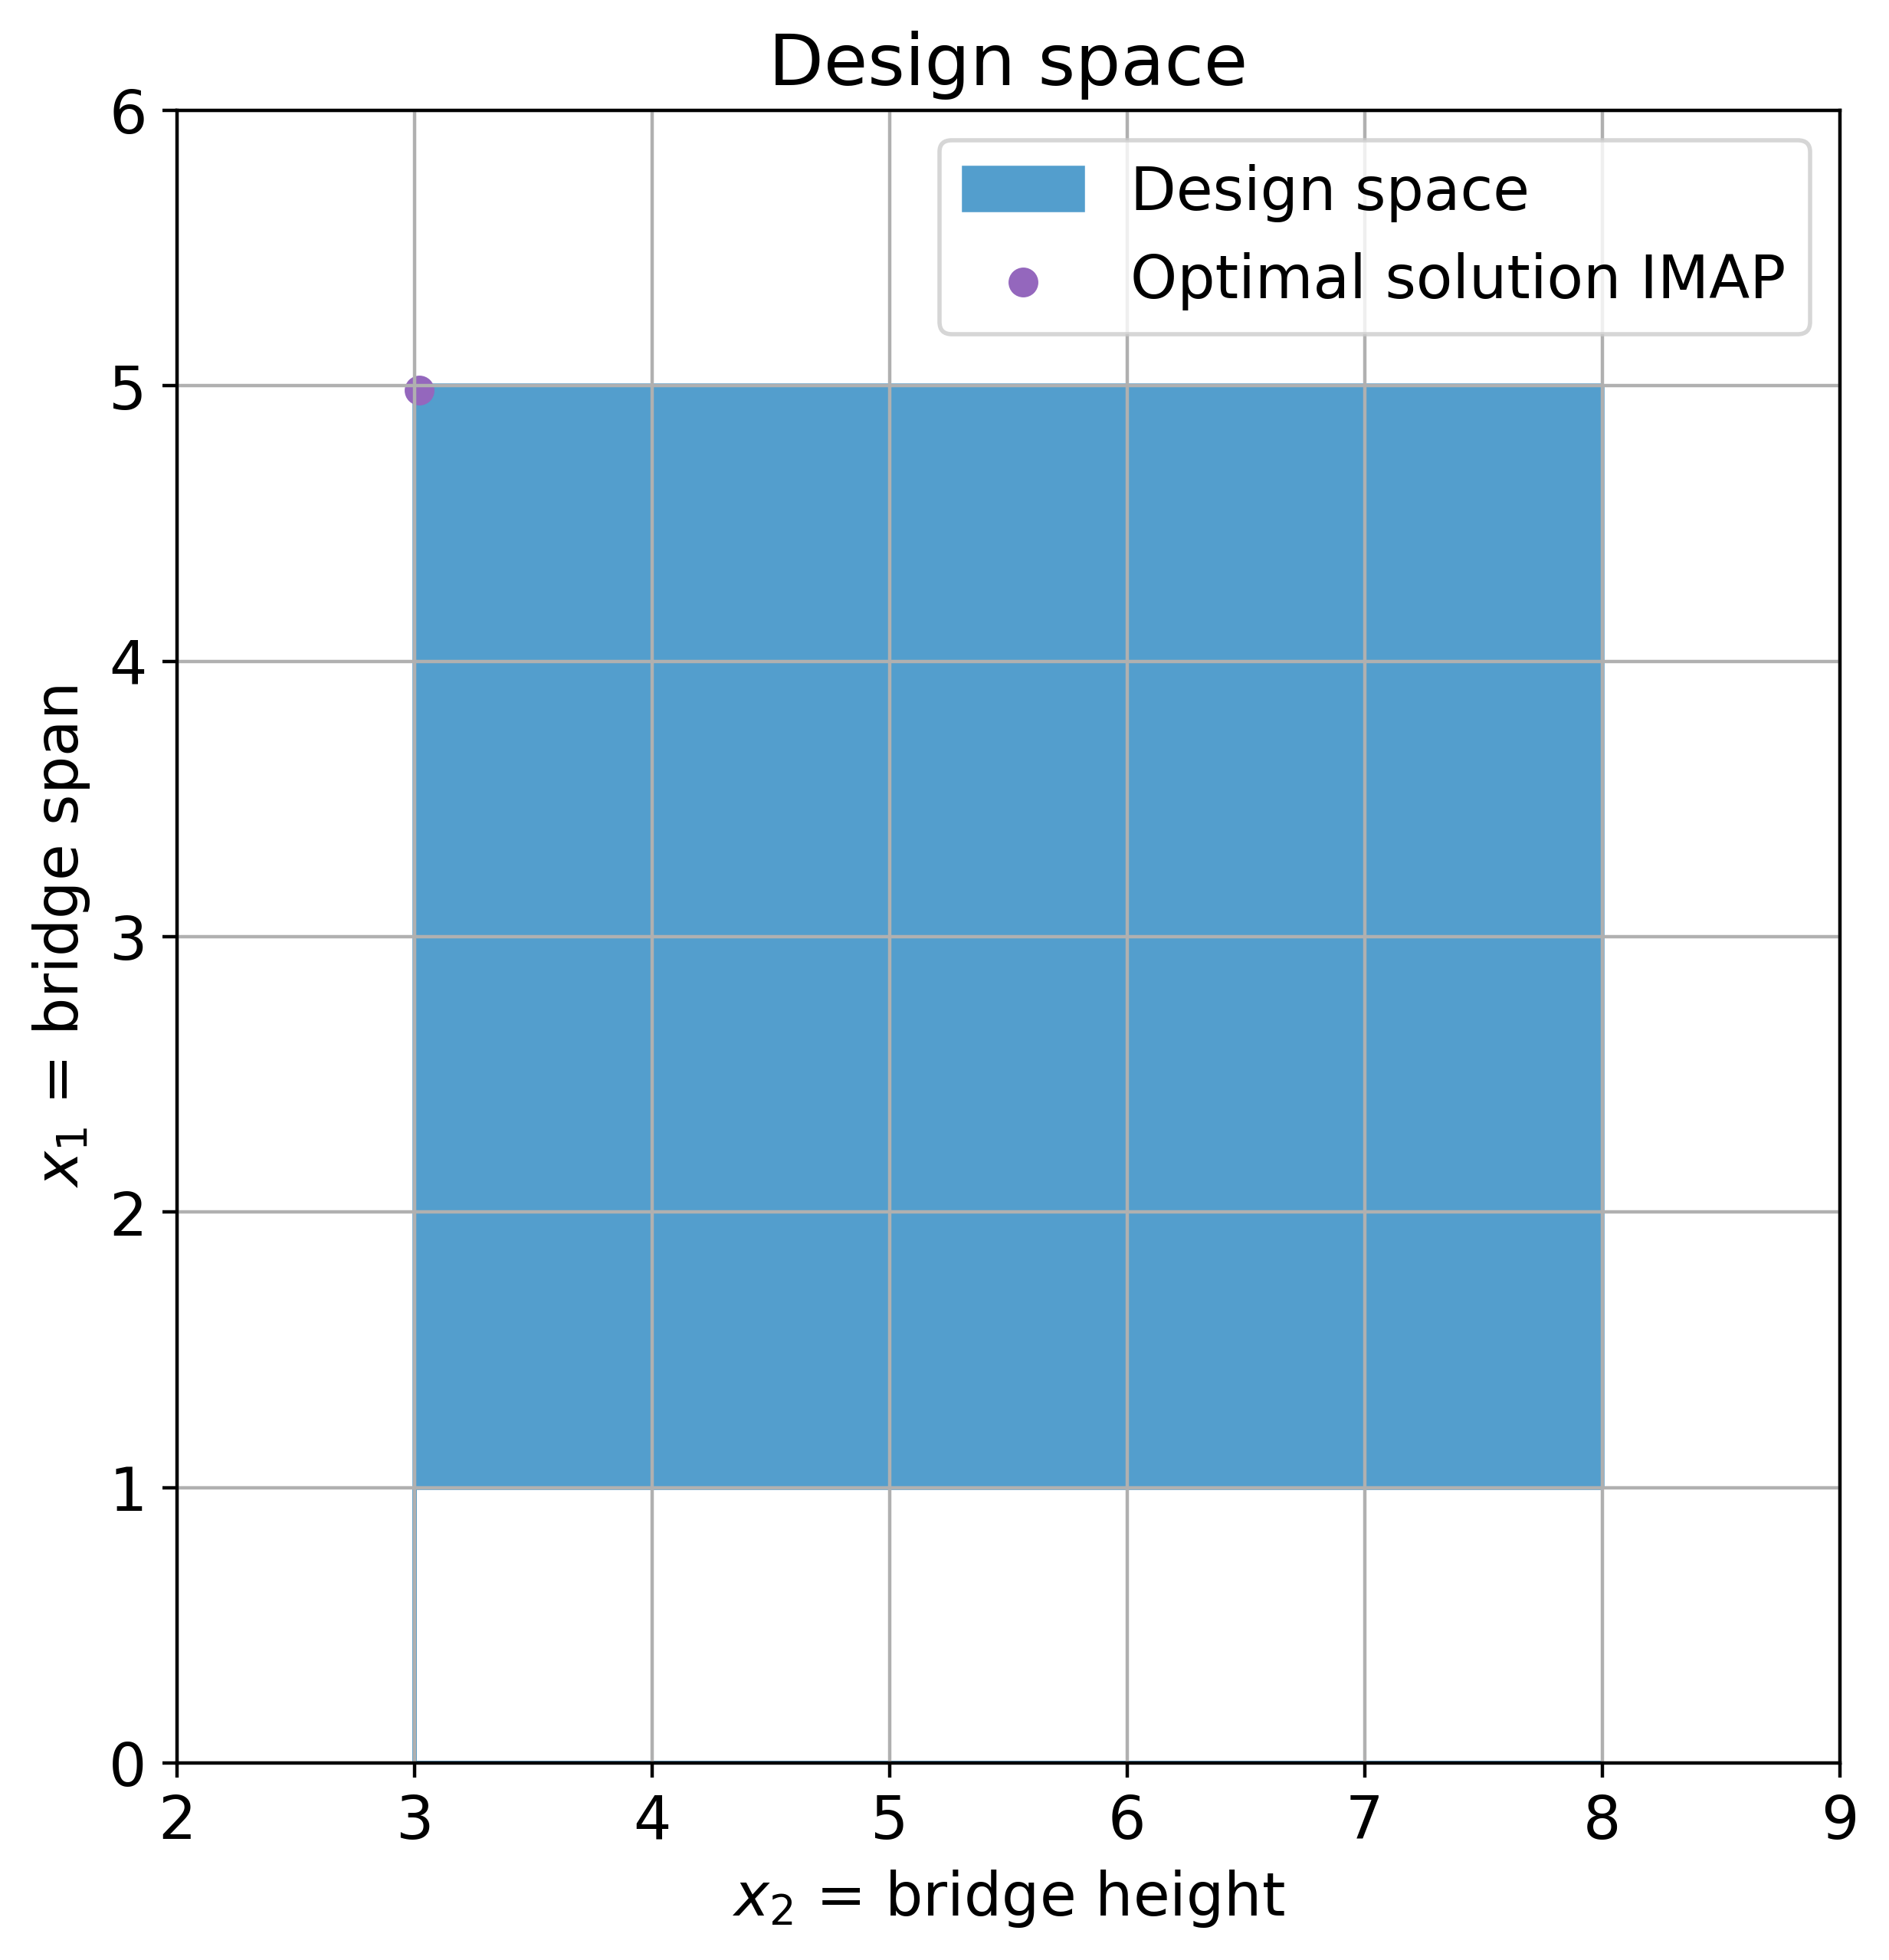

In [54]:
# create figure that shows the results in the design space
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim((2, 9))
ax.set_ylim((0, 6))
ax.set_xlabel(r'$x_2$ = bridge height')
ax.set_ylabel(r'$x_1$ = bridge span')
ax.set_title('Design space')

# define corner points of design space
x_fill = [3, 8, 8, 3]
y_fill = [1, 1, 5, 5]

ax.fill_between(x_fill, y_fill, color='#539ecd', label='Design space')
ax.scatter(design_variables[1], design_variables[0], label='Optimal solution IMAP', color='tab:purple')

ax.grid()  # show grid
ax.legend();  # show legend